### Linear Regression Model Basic
#### Data 200 - Graduate Student Final Project
#### Team Members: Erin Jones, Filipe Santos

The following notebook shows our feature engineering and data cleaning efforts for a small subset of the total users. When attempting to run the model on all 500 users in the originally generated sample, the notebook crashed, so we are working with a small sample for the number of workouts we run the model on. That said it is important to note the difference of sample in the context of the original raw dataset and sample for the purposes of our model and x/y splits etc.

We randomly selected 500 users to work with from the original dataset. This can be considered our sampling frame for the purposes of this investigation. From these 500 users, which were shuffled based on the creation of the dictionary in which they were stored (see raw_parse.ipyb), we took 20 to complete EDA on for the purposes of the linear regression model (see eda_2.ipynb). In our experiment, we are considering the creation of a specialized linear regression model that is uniquely trained for each user producing custom results based on the user's past workouts. In this sense, when considering train/test split and validation and the granularity of data and number of entries, each user has thousands of data points which are being used to train their unique model. The granularity is at the level of timestamps for that particular user's workout, which is bound by the sampling rate for their wearable device. For 20 users, we are theoretically dealing with ~500 stamps per workout and ~100 workouts per user, which adds up to about 50,000 data points per user and thus ~1 million data points being processed. Given that we are granted no funding for added computational power for the purposes of this project, limiting the number of users we run this model on is reasonable.

In [1]:
# IMPORTS

# Data Manipulation
import pandas as pd
import numpy as np
import random
import pickle
from math import radians, cos, sin, asin, sqrt

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Time zone + time stamp work
from timezonefinder import TimezoneFinder
import datetime
import pytz

# Sklearn model generation
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as lm
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

Importing the pickle below sped up the process of accessing the 500 randomly selected and ordered users, as created in raw_parse.ipynb. Now, the 500 samples are accessible in a matter of 3 seconds due to the efficiency of the binary storage method

In [5]:
# open pickle file to work with 
with open('./data/500_user.pkl', 'rb') as file:
    # dump into dictionary object
    users_dict = pickle.load(file)

# ensure load worked properly
for user, df in users_dict.items():
    print(len(users_dict))
    display(df.head())
    break

500


,since_begin,since_last,tar_derived_speed,heart_rate,distance,sport,tar_heart_rate,derived_speed,id,timestamp,altitude,gender,time_elapsed,longitude,latitude,userId,workout_n
0,-14.805054,-0.01158,0.000000,8.532873,-4.372304,run,179,-7.082944,649100510,1451317040,0.038282,male,-0.122568,25.276541,54.750948,1413935,35004
1,-14.805054,-0.01158,9.925434,8.532873,-2.989371,run,179,-3.134742,649100510,1451317046,0.023704,male,-0.122300,25.276727,54.750845,1413935,35004
2,-14.805054,-0.01158,11.857894,8.532873,-2.995481,run,179,-2.366035,649100510,1451317051,0.009125,male,-0.122077,25.276908,54.750740,1413935,35004
3,-14.805054,-0.01158,10.866049,8.321098,-3.110645,run,178,-2.760578,649100510,1451317056,0.009125,male,-0.121854,25.277104,54.750665,1413935,35004
4,-14.805054,-0.01158,13.632061,6.626896,-2.472918,run,170,-1.660296,649100510,1451317062,-0.005454,male,-0.121587,25.277388,54.750543,1413935,35004


Next, we sample 100 users for the purposes of running the linear model however we must break it into subsets so we can capture information as we go and the notebook doesn't get flagged as idle and timeout.

as it takes ~1hr to run this first model on this many users. Forty users still represents a significant amount of timestamps/rows to process at the given granularity, so we feel that 40 represents a reasonable sample given computational limitations and lack of funding to purchase computing power for the purposes of this course.

In [50]:
# create a list of subsamples

random.seed(42)
num_samples = 10
keys_per_sample = 10
all_keys = list(users_dict.keys())

subsamples = []

for _ in range(num_samples):
    sampled_keys = random.sample(all_keys, keys_per_sample)
    subsample_dict = {key: users_dict[key] for key in sampled_keys}
    subsamples.append(subsample_dict)

    # remove the sampled keys from all_keys to ensure uniqueness in subsequent samples
    all_keys = [key for key in all_keys if key not in sampled_keys]

subsample_a = subsamples[0]
subsample_b = subsamples[1]
subsample_c = subsamples[2]
subsample_d = subsamples[3]
subsample_e = subsamples[4]
subsample_f = subsamples[5]
subsample_g = subsamples[6]
subsample_h = subsamples[7]
subsample_i = subsamples[8]
subsample_j = subsamples[9]

#### Data Cleaning

To clean our data in the pipeline, we are using a threshold method that sets and upper and lower fence three standard deviations away from the mean to trim those datapoints deemed to be anomalous based on their z-score. This function allows for the limited amount of cleaning desired for the initial run through of the pipeline.

In [7]:
def remove_outliers(data, variable, upper=None, lower=None): 
    df = data.copy()
    mean = df[variable].mean()
    std = df[variable].std()
    if upper:
        upper_fence = upper
    else:
        upper_fence = mean + (3*std)
    if lower:
        lower_fence = lower
    else:    
        lower_fence = mean - (3*std)
    df = (df[(df[variable] >= lower_fence) & (df[variable] <= upper_fence)]).copy()
    return df

#### Feature Engineeering

The cell below adds the following helping functions to engineer new features in the raw data:
* datetime inclusive of timezone based on pytz library using lat/long coordinates
* time of day categorical variable representing night, early morning, mid morning, midday, early afternoon, late afternoon, and evening
* minutes elapsed in a gift workout
* log transformation
* one hot encoding of a categorical variable (in this case used on the sport column from the original data which is nominal)
* haversine column, which represents each lat/long point numerically

In [8]:
# Define a function to calculate timezone for a group
def add_dt(data):

    def calculate_timezone(group_df):
        lat = group_df['latitude'].iloc[0]
        long = group_df['longitude'].iloc[0]
        try:
            # Create a TimezoneFinder object
            tf = TimezoneFinder()
            # Find the timezone based on coordinates
            timezone = tf.timezone_at(lng=long, lat=lat)
        except:
            timezone = 'UTC'
        return timezone
    
    def create_datetime(row):
        
        # Unix timestamp
        ts = row['timestamp']

        # Specify the timezone (e.g., 'America/New_York')
        desired_timezone = row['tz']

        # Convert Unix timestamp to a datetime object with the desired timezone
        datetime_obj = datetime.datetime.utcfromtimestamp(ts)
        desired_timezone_obj = pytz.timezone(desired_timezone)
        localized_datetime = desired_timezone_obj.localize(datetime_obj)
        

        # # Format the localized datetime object as a string
        # formatted_date_time = localized_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')
        return localized_datetime

    # Group the DataFrame by the 'Group' column and calculate timezone
    grouped_timezone = data.groupby('workout_n').apply(calculate_timezone)
    # Use transform to broadcast timezone to all rows in each group
    data['tz'] = data['workout_n'].map(grouped_timezone)
    data['datetime'] = data.apply(create_datetime,axis=1)
    
    return data

def add_tod(data):
    """
    Adds a new column to the dataframe categorizing the time of day based on the timestamp.

    Categories:
    0 - Night (00:00-04:59)
    1 - Early Morning (05:00-06:59)
    2 - Mid Morning (07:00-08:59)
    3 - Midday (09:00-10:59)
    4 - Early Afternoon (11:00-13:59)
    5 - Late Afternoon (14:00-16:59)
    6 - Evening (17:00-23:59)

    Parameters:
    data (pd.DataFrame): input workout timeseries
    column (str): column containing the timestamp.

    Returns:
    pd.DataFrame: The DataFrame with the new categorization column.
    """

    def get_time_category(hour):
        if 0 <= hour <= 4:
            return 0  # Night
        elif 5 <= hour <= 6:
            return 1  # Early Morning
        elif 7 <= hour <= 8:
            return 2  # Mid Morning
        elif 9 <= hour <= 10:
            return 3  # Midday
        elif 11 <= hour <= 13:
            return 4  # Early Afternoon
        elif 14 <= hour <= 16:
            return 5  # Late Afternoon
        else:
            return 6  # Evening

    if 'datetime' in data.columns:
    #     # Extract hour from the timestamp
    #     # Create a new column by extracting the hour from the datetime column
        data['hour'] = data['datetime'].apply(lambda x: x.hour)
        data['time_category'] = data['hour'].apply(get_time_category)
    else:
        raise ValueError(f"Column 'datetime' not found in DataFrame.")

    return data

def add_mins_elapsed(data):

    def cumulative_by_group(group_df):

        # calc the running difference
        group_df['diff'] = (group_df['timestamp'].diff())/60
        # fill row 1
        group_df['diff'].iloc[0] = 0
        # calculate the cumulative sum
        group_df['elapsed'] = group_df['diff'].cumsum()

        return group_df

    grouped = data.groupby('workout_n')
    data = grouped.apply(cumulative_by_group)
    data.reset_index(drop=True, inplace=True)

    return data

def log_transform(data, **columns):
    def conditional_log(value):
        if value >= 1:
            return np.log(value)
        else:
            return value 
    for col, name in columns.items():
        data[f'log_{name}'] = data[name].apply(conditional_log)
    return data

def ohe_categorical(data, column_name):
    """
    One-hot-encodes categorical variable. New columns are of the form "'col_name'_NUMBER".
    We drop the first column to allow the intercept to remain in the regression model while
    avoiding multicollinearity
    """
    enc = OneHotEncoder(drop='first')
    o_h_e = (enc.fit_transform(data[[column_name]])).toarray()
    one_hot_encoded_df = (pd.DataFrame(o_h_e, columns=enc.get_feature_names_out([column_name]))).set_index(data.index)
    data = data.merge(one_hot_encoded_df, left_index=True, right_index=True)
    return data

def add_haversine_col(data):
    def single_pt_haversine(row):
        """
        'Single-point' Haversine: Calculates the great circle distance
        between a point on Earth and the (0, 0) lat-long coordinate
        """
        lat = row['latitude']
        lng = row['longitude']
        r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

        lat, lng = map(radians, [lat, lng])
            
        # 'Single-point' Haversine formula
        a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
        d = 2 * r * asin(sqrt(a)) 
        
        return d
    data['haversine'] = data.apply(single_pt_haversine, axis=1)
    return data

### Instantiate Cross-Validator + Feature Selector

The following cell instantiates the RFECV which runs a regression model with all features and then recursively eliminates them using the Time Series Split cross validator that preserves the order of the time series. The cross validator removes one feature each time (step 1) and uses five folds (n_splits=5). These were generic hyperparameters that seemed to work well, however step could be increased and the number of folds could be decreased to reduce the amount of computational power needed to run the model.

In [9]:
def getFeatures(X,Y):
    X = X.select_dtypes(include='number')

    # Create a classifier
    lr = LinearRegression()

    # TimeSeriesSplit cross-validator
    cv = TimeSeriesSplit(n_splits=5)

    # RFECV with TimeSeriesSplit
    selector = RFECV(estimator=lr, step=1, cv=cv, scoring='neg_mean_squared_error')

    selector.fit(X,Y)

    selected_features = (X.columns[selector.support_]).tolist()

    # returns features selected by the RFECV algorithm as a list
    return selected_features

### Create Initial Pipeline

The following code is largely based on the pipeline created for Project A2 when developing a regression model for the cook county office.

In [10]:
# Data pipeline processing, as pulled from Project 2
def process_data_pipe(data, pipeline_functions, prediction_col=None, features=None):

    # run pipeline functions
    for function, positional_arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not positional_arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (positional_arguments):
            data = data.pipe(function, *positional_arguments)
        else:
            data = data.pipe(function)
    

    # create x_y split
    if prediction_col:
        df = data.dropna()
        # drop interim columns added prior to running feature selector
        X = df.drop(columns=[prediction_col,'latitude', 'longitude', 'timestamp', 'hour', 'time_elapsed', 'diff'])
        y = df.loc[:, prediction_col]
        # run feature selector
        feats = getFeatures(X,y)
        # trim design matrix to only include features selected by RFECV
        X = (X.loc[:,feats]).copy()
        return X, y, feats
    
    # pull x for the given set
    else:
        X = data.loc[:,features]
        return X

def process_data_final(data, is_test_set=False, features=None):
    
    df = data.copy()
    drop_cols = ['since_begin', 'since_last', 'id', 'gender', 'userId', 'heart_rate', 'derived_speed']
    mod_cols = [col for col in drop_cols if col in df.columns]
    
    # drop columns with data which is not useful
    df.drop(columns=mod_cols, inplace=True)

    # need to confirm that we would like to do this
    df.dropna(inplace=True)

    processing_all = [
        (ohe_categorical, None, {'column_name': 'sport'}), 
        (add_haversine_col, None, None), 
        (add_dt, None, None), 
        (add_tod, None, None),
        (add_mins_elapsed, None, None),
        ]
    
    # Training set
    if not is_test_set:
        processing_training = [
            (remove_outliers, None, {'variable': 'tar_heart_rate'}), 
            # (log_transform, None, {'col': 'tar_heart_rate'})
            ]
        processing_steps = processing_training + processing_all
        X, y, features = process_data_pipe(df, pipeline_functions=processing_steps, prediction_col='tar_heart_rate', features=None)
        return X, y, features
    
    # Test set
    else:
        processing_steps = processing_all
        X = process_data_pipe(df, pipeline_functions=processing_steps, prediction_col=None, features=features)
        return X
  

### Evaluation Metrics

Instantiate RMSE formula to calculate and compare error

In [11]:
# Evaluation Metrics

def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

### Run Round 1 and Evaluate Results 

Note, the cell below, despite using dictionaries to preserve memory, takes ~1hr to run on an M2 macbook pro with 32 GB of ram. It is a heavy cell and as such, initial results are also written and stored in CSV files in the cells below this cell.

In [52]:
# formula that instantiates and runs the model
def split_and_run(dataframe, user_id):

    # dictionaries for storing data
    train_dict = {}
    test_dict = {}

    X, y, feats = process_data_final(dataframe)

    # shuffle = False to preserve time series
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

    # first ohe is dropped to prevent multi-collinearity and allow for intercept
    model = lm.LinearRegression(fit_intercept=True)

    # fit model
    model.fit(X_train, y_train)

    # compute fitted (based on training set) and predicted (based on test set)
    y_fitted = model.predict(X_train)
    y_predicted = model.predict(X_test)
    
    # calculate error metric
    fitted_rmse = rmse(y_fitted, y_train)
    predicted_rmse = rmse(y_predicted, y_test)

    # add results to a dictionary indexed by user for easy access and transformation into dataframes
    # later, but low memory use when running this cell
    train_dict[user_id] = [fitted_rmse, X_train, y_train, y_fitted, feats] 
    test_dict[user_id] = [predicted_rmse, X_test, y_test, y_predicted]

    return train_dict, test_dict

### Run Model

Jupyter will time out if you don't run this model on 100 users as separate chunks of users, unfortunately. It is possible to change the settings file for jupyter but for ease of reproducing our results, the below code, which is commented out, can be run and at the end, a pickle file can be created to save and download the results. The lines have been commented out as each takes 5 - 9 minutes to run and it will be easiest to reproduce graphs below investigating the results by simply using the loaded pickle files.

In [ ]:
# Instantiate dictionaries for storing overall data
# users_train = {}
# users_test = {}

In [53]:
# Create and collect results for the ten users part of subsample a
# for user, data in subsample_a.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train.update(train_results)
#     users_test.update(test_results)    

In [54]:
# Create and collect results for the ten users part of subsample b
# for user, data in subsample_b.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train.update(train_results)
#     users_test.update(test_results)     

In [55]:
# Create and collect results for the ten users part of subsample c
# for user, data in subsample_c.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train.update(train_results)
#     users_test.update(test_results)     

In [57]:
# Create and collect results for the ten users part of subsample d
# for user, data in subsample_d.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train.update(train_results)
#     users_test.update(test_results)    

In [61]:
# Create and collect results for the ten users part of subsample e
# for user, data in subsample_e.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train.update(train_results)
#     users_test.update(test_results)    

In [64]:
# Create a new dictionary so the joining doesn't take as long for the below
# users_train_2 = {}
# users_test_2 = {}

In [65]:
# Create and collect results for the ten users part of subsample f
# for user, data in subsample_f.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train_2.update(train_results)
#     users_test_2.update(test_results)     

In [66]:
# Create and collect results for the ten users part of subsample g
# for user, data in subsample_g.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train_2.update(train_results)
#     users_test_2.update(test_results)     

In [67]:
# Create and collect results for the ten users part of subsample h
# for user, data in subsample_h.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train_2.update(train_results)
#     users_test_2.update(test_results)     

In [68]:
# Create and collect results for the ten users part of subsample i
# for user, data in subsample_i.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train_2.update(train_results)
#     users_test_2.update(test_results)   

In [69]:
# Create and collect results for the ten users part of subsample j
# for user, data in subsample_j.items():
#     train_results, test_results = split_and_run(data, user)
#     users_train_2.update(train_results)
#     users_test_2.update(test_results)  

Code to pickle and combine results dictionaries is included below, should you wish to reproduce results and save them for easy access at a later time. 

In [77]:
# users_train.update(users_train_2)
# users_test.update(users_test_2)

# with open('mega_train_lm.pkl', 'wb') as file:
#     # Use pickle.dump to write the dictionary to the file
#     pickle.dump(users_train, file)
# with open('mega_test_lm.pkl', 'wb') as file:
#     # Use pickle.dump to write the dictionary to the file
#     pickle.dump(users_test, file)

As a reminder:

* the output for the mega_train_lm.pkl file when loaded is a dictionary containing results for the fitted data(training x and y) and is of the format:
>- key = user id
>- value = tuple(fitted_rmse, X_train, y_train, y_fitted, feats)

* the output for the mega_test_lm.pkl file when loaded is a dictionary containing results for the test data(test x and y) and is of the format:
>- key = user id
>- value = tuple(predicted_rmse, X_test, y_test, y_predicted)

both must first be transferred to the data folder and then can be loaded with the following code...

```
with open('./data/mega_train_lm.pkl', 'rb') as file:
    training_results = pickle.load(file)

with open('./data/mega_test_lm.pkl', 'rb') as file:
    testing_results = pickle.load(file)
```

## Visualize Results

In [83]:
# import and process data
with open('./data/mega_train_lm.pkl', 'rb') as file:
    training_results = pickle.load(file)

with open('./data/mega_test_lm.pkl', 'rb') as file:
    testing_results = pickle.load(file)

# create df for ease of manipulation and graphing for rmse
data_train = [(key, *value) for key, value in training_results.items()]
df_train = pd.DataFrame(data_train, columns=['user_id', 'rmse', 'x_train', 'y_train', 'y_fitted', 'feats'])

data_test = [(key, *value) for key, value in testing_results.items()]
df_test = pd.DataFrame(data_test, columns=['user_id', 'rmse', 'x_test', 'y_test', 'y_predicted'])


#### Calculate average RMSE for both train and test sets

In [89]:
print("The fitted results (training set) for running Model 1 on our sample of 100 users are as follows:")
display(df_train['rmse'].describe())
print("-----------------------------------------------------------")
print("\nThe predicted results (testing set) for running model one on our sample of 100 users are as follows:")
display(df_test['rmse'].describe())
print("-----------------------------------------------------------")


The fitted results (training set) for running Model 1 on our sample of 100 users are as follows:


count    100.000000
mean      14.931908
std        4.052749
min        2.151056
25%       12.415122
50%       15.112101
75%       17.074246
max       25.687783
Name: rmse, dtype: float64

-----------------------------------------------------------

The predicted results (testing set) for running model one on our sample of 100 users are as follows:


count    1.000000e+02
mean     1.408796e+11
std      1.408796e+12
min      7.119931e-02
25%      1.299467e+01
50%      1.552946e+01
75%      1.870121e+01
max      1.408796e+13
Name: rmse, dtype: float64

-----------------------------------------------------------


There are absolutely a handful of outliers in the test sets that are getting smacked with the model overfitting the training data. This can be seen in the distribution, where the mean is huge, but the median is around 15, which is very similar to the mean for the training data. This is a big risk with time series train/test split as you run risk of a user starting a new kind of workout in the last 25% of the data and things potentially being way out of wack. This also begs for a more robust handling of outliers in model 2. A plot for good measure...

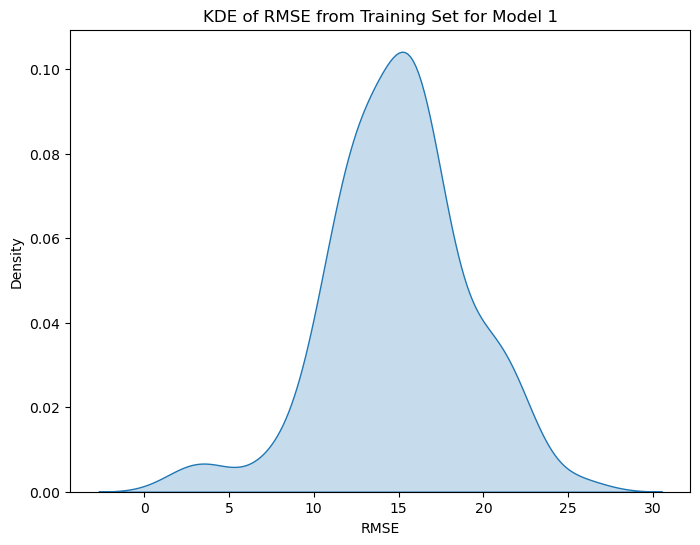

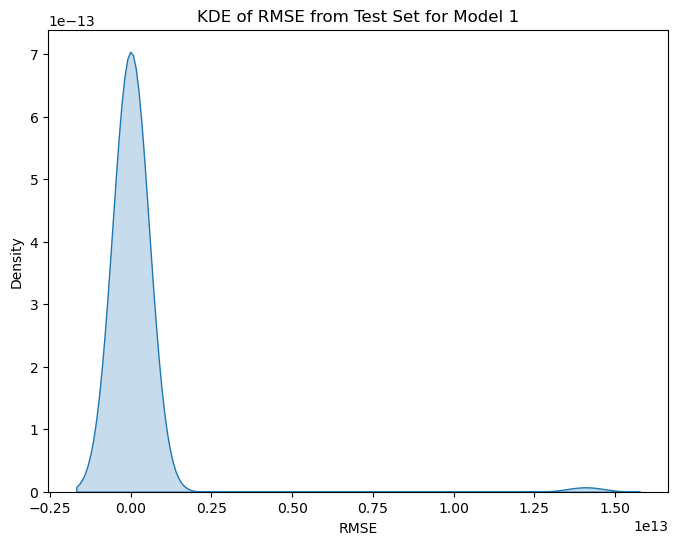

In [96]:
# plot kde for training rmse
plt.figure(figsize=(8, 6))
sns.kdeplot(df_train['rmse'], fill=True, label='RMSE Training Set')
plt.xlabel('RMSE')
plt.ylabel('Density')
plt.title('KDE of RMSE from Training Set for Model 1')
plt.show()

# plot kde for testing rmse
plt.figure(figsize=(8, 6))
sns.kdeplot(df_test['rmse'], fill=True, label='RMSE Testing Set')
plt.xlabel('RMSE')
plt.ylabel('Density')
plt.title('KDE of RMSE from Test Set for Model 1')
plt.show()

Let's take a closer look at what is going on in the three best and three worst performing models within the test set, as the curve for the training set looks reasonable. Especially knowing the results from the Ni and all paper.

In [99]:
def get_users_with_xtreme_results(your_dict):
    # sort dictionary items by RMSE
    sorted_items = sorted(your_dict.items(), key=lambda x: x[1][0])

    # extract three (lowest) and three (highest) keys
    lowest_keys = [item[0] for item in sorted_items[:3]]
    highest_keys = [item[0] for item in sorted_items[-3:]]

    return lowest_keys, highest_keys

lowest, highest = get_users_with_xtreme_results(testing_results)
print("The model performs as follows on the test set:")
print(f"\nTop Three:")
print(f"\n\t* {lowest[0]} - RMSE {testing_results[lowest[0]][0]} - Features {training_results[lowest[0]][-1]}")
print(f"\n\t* {lowest[1]} - RMSE {testing_results[lowest[1]][0]} - Features {training_results[lowest[1]][-1]}")
print(f"\n\t* {lowest[2]} - RMSE {testing_results[lowest[2]][0]} - Features {training_results[lowest[2]][-1]}")
print(f"\nBottom Three:")
print(f"\n\t* {highest[0]} - RMSE {testing_results[highest[0]][0]} - Features {training_results[highest[0]][-1]}")
print(f"\n\t* {highest[1]} - RMSE {testing_results[highest[1]][0]} - Features {training_results[highest[1]][-1]}")
print(f"\n\t* {highest[2]} - RMSE {testing_results[highest[2]][0]} - Features {training_results[highest[2]][-1]}")

The model performs as follows on the test set:

Top Three:

	* 1040960 - RMSE 0.07119931454479282 - Features ['distance', 'altitude', 'time_category']

	* 9359950 - RMSE 3.581176864498688 - Features ['altitude']

	* 8484809 - RMSE 5.574800453903862 - Features ['altitude']

Bottom Three:

	* 1663599 - RMSE 36.84491229172437 - Features ['sport_bike (transport)', 'sport_core stability training']

	* 3232625 - RMSE 44.001528016565054 - Features ['distance', 'altitude', 'sport_hiking', 'haversine']

	* 9937628 - RMSE 14087958870389.94 - Features ['tar_derived_speed', 'distance', 'altitude', 'sport_mountain bike', 'sport_run', 'sport_walk', 'haversine', 'time_category']


And the very bizarre case with a *huge* RMSE has fallen out. It will be interesting to look at both the time series plots with the prediction overlay for these users as well as the features being selected by the RFECV. These numbers [1040960, 9359950, 8484809, 1663599, 3232625, 9937628] are the user IDs whose test sets were most well and least well represented by model one (from best to worst respectively). They will be taken to eda_3 to be evaluated further.